# **[IntoAI] WEEK9 : Convnet**

### **0. 기본 환경 세팅**

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/케라스-창시자에게-배우는-딥러닝/) 책의 5장 1~3절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

In [ ]:
import keras
keras.__version__

### **1.합성곱 신경망 소개**

컨브넷의 정의와 컨브넷이 컴퓨터 비전 관련 작업에 잘 맞는 이유에 대해 이론적 배경을 알아보겠습니다. 하지만 먼저 간단한 컨브넷 예제를 둘러 보죠. 2장에서 완전 연결 네트워크로 풀었던(이 방식의 테스트 정확도는 97.8%였습니다) MNIST 숫자 이미지 분류에 컨브넷을 사용해 보겠습니다. 기본적인 컨브넷이더라도 2장의 완전 연결된 모델의 성능을 훨씬 앞지를 것입니다.

다음 코드는 기본적인 컨브넷의 모습입니다. `Conv2D`와 `MaxPooling2D` 층을 쌓아 올렸습니다. 잠시 후에 이들이 무엇인지 배우겠습니다.

컨브넷이 `(image_height, image_width, image_channels)` 크기의 입력 텐서를 사용한다는 점이 중요합니다(배치 차원은 포함하지 않습니다). 이 예제에서는 MNIST 이미지 포맷인 `(28, 28, 1)` 크기의 입력을 처리하도록 컨브넷을 설정해야 합니다. 이 때문에 첫 번째 층의 매개변수로 `input_shape=(28, 28, 1)`을 전달합니다.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

지금까지 컨브넷 구조를 출력해 보죠:

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


`Conv2D`와 `MaxPooling2D` 층의 출력은 `(height, width, channels)` 크기의 3D 텐서입니다. 높이와 넓이 차원은 네트워크가 깊어질수록 작아지는 경향이 있습니다. 채널의 수는 `Conv2D` 층에 전달된 첫 번째 매개변수에 의해 조절됩니다(32개 또는 64개).

다음 단계에서 마지막 층의 (`(3, 3, 64)` 크기인) 출력 텐서를 완전 연결 네트워크에 주입합니다. 이 네트워크는 이미 익숙하게 보았던 `Dense` 층을 쌓은 분류기입니다. 이 분류기는 1D 벡터를 처리하는데 이전 층의 출력이 3D 텐서입니다. 그래서 먼저 3D 출력을 1D 텐서로 펼쳐야 합니다. 그다음 몇 개의 `Dense` 층을 추가합니다:

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

10개의 클래스를 분류하기 위해 마지막 층의 출력 크기를 10으로 하고 소프트맥스 활성화 함수를 사용합니다. 이제 전체 네트워크는 다음과 같습니다:

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

여기에서 볼 수 있듯이 `(3, 3, 64)` 출력이 `(576,)` 크기의 벡터로 펼쳐진 후 `Dense` 층으로 주입되었습니다.

이제 MNIST 숫자 이미지에 이 컨브넷을 훈련합니다. 2장의 MNIST 예제 코드를 많이 재사용하겠습니다.

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.1786 - acc: 0.9441
Epoch 2/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0487 - acc: 0.9853
Epoch 3/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0339 - acc: 0.9892
Epoch 4/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0253 - acc: 0.9921
Epoch 5/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0191 - acc: 0.9943


테스트 데이터에서 모델을 평가해 보죠:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 32us/step


In [ ]:
test_acc

0.9898

2장의 완전 연결 네트워크는 97.8%의 테스트 정확도를 얻은 반면, 기본적인 컨브넷은 99.2%의 테스트 정확도를 얻었습니다. 에러율이 (상대적으로) 64%나 줄었습니다. 나쁘지 않군요!

### **2. 소규모 데이터셋에서 컨브넷 사용하기**

#### **소규모 데이터셋에서 밑바닥부터 컨브넷을 훈련하기**

매우 적은 데이터를 사용해 이미지 분류 모델을 훈련하는 일은 흔한 경우입니다. 여러분이 전문적인 컴퓨터 비전 작업을 한다면 실제로 이런 상황을 마주치게 될 가능성이 높습니다.

보통 '적은' 샘플이란 수백 개에서 수만 개 사이를 의미합니다. 실용적인 예제로 4,000개의 강아지와 고양이 사진(2,000개는 강아지, 2,000개는 고양이)으로 구성된 데이터셋에서 강아지와 고양이 이미지를 분류해 보겠습니다. 훈련을 위해 2,000개의 사진을 사용하고 검증과 테스트에 각각 1,000개의 사진을 사용하겠습니다.

이 절에서 문제를 해결하기 위해 기본적인 전략 하나를 살펴볼 것입니다. 보유한 소규모 데이터셋을 사용해 처음부터 새로운 모델을 훈련하는 것입니다. 2,000개의 훈련 샘플에서 작은 컨브넷을 어떤 규제 방법도 사용하지 않고 훈련하여 기준이 되는 기본 성능을 만들겠습니다. 이 방법은 71%의 분류 정확도를 달성할 것입니다. 이 방법의 주요 이슈는 과대적합이 될 것입니다. 그다음 컴퓨터 비전에서 과대적합을 줄이기 위한 강력한 방법인 데이터 증식을 소개하겠습니다. 데이터 증식을 통해 네트워크의 성능을 82% 정확도로 향상시킬 것입니다.

다음 절에서 작은 데이터셋에 딥러닝을 적용하기 위한 핵심적인 기술 두 가지를 살펴보겠습니다. 사전 훈련된 네트워크로 특성을 추출하는 것(90%에서 96%의 정확도를 얻게 됩니다)과 사전 훈련된 네트워크를 세밀하게 튜닝하는 것입니다(최종 모델은 97% 정확도를 얻을 것입니다). 이런 세 가지 전략(처음부터 작은 모델을 훈련하기, 사전 훈련된 모델을 사용해 특성 추출하기, 사전 훈련된 모델을 세밀하게 튜닝하기)은 작은 데이터셋에서 이미지 분류 문제를 수행할 때 여러분의 도구 상자에 포함되어 있어야 합니다.

#### **작은 데이터셋 문제에서 딥러닝의 타당성**

딥러닝은 데이터가 풍부할 때만 작동한다는 말을 이따금 듣습니다. 부분적으로는 맞습니다. 딥러닝의 근본적인 특징은 훈련 데이터에서 특성 공학의 수작업 없이 흥미로운 특성을 찾을 수 있는 것입니다. 이는 훈련 샘플이 많아야만 가능합니다. 입력 샘플이 이미지와 같이 매우 고차원인 문제에서는 특히 그렇습니다.

하지만 많은 샘플이 의미하는 것은 상대적입니다. 우선 훈련하려는 네트워크의 크기와 깊이에 상대적입니다. 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만을 사용해서 훈련하는 것은 불가능합니다. 하지만 모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있습니다. 컨브넷은 지역적이고 평행 이동으로 변하지 않는 특성을 학습하기 때문에 지각에 관한 문제에서 매우 효율적으로 데이터를 사용합니다. 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다. 이 절에서 실제로 이런 결과를 보게 될 것입니다.

거기에 더해 딥러닝 모델은 태생적으로 매우 다목적입니다. 말하자면 대규모 데이터셋에서 훈련시킨 이미지 분류 모델이나 스피치-투-텍스트 모델을 조금만 변경해서 완전히 다른 문제에 재사용할 수 있습니다. 특히 컴퓨터 비전에서는 (보통 ImageNet 데이터셋에서 훈련된) 사전 훈련된 모델들이 다운로드받을 수 있도록 많이 공개되어 있어서 매우 적은 데이터에서 강력한 비전 모델을 만드는데 사용할 수 있습니다. 바로 다음 절에서 우리가 해볼 것입니다.

먼저 데이터를 구하는 것부터 시작해 보죠.

#### **데이터 내려받기**

여기서 사용할 강아지 vs. 고양이 데이터셋은 케라스에 포함되어 있지 않습니다. 컨브넷이 주류가 되기 전인 2013년 후반에 캐글에서 컴퓨터 비전 경연 대회의 일환으로 이 데이터셋을 만들었습니다. 원본 데이터셋을 `https://www.kaggle.com/c/dogs-vs-cats/data`에서 내려받을 수 있습니다(캐글 계정이 없다면 하나 만들어야 하지만 계정을 만드는 과정은 간단합니다). 실습의 편의를 위해서 번역서의 깃허브에는 이 데이터셋을 미리 다운로드하여 포함하였습니다.

이 사진들은 중간 정도의 해상도를 가진 컬러 JPEG 파일입니다. 다음이 몇 개 샘플입니다:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

당연히 2013년 강아지 vs. 고양이 캐글 경연은 컨브넷을 사용한 참가자가 우승하였습니다. 최고 성능은 95%의 정확도를 달성했습니다. 이 예제를 가지고 (다음 절에서) 참가자들이 사용했던 데이터의 10%보다 적은 양으로 모델을 훈련하고도 이와 아주 근접한 정확도를 달성해 보겠습니다.

이 데이터셋은 25,000개의 강아지와 고양이 이미지(클래스마다 12,500개)를 담고 있고 (압축해서) 543MB 크기입니다. 다운로드하고 압축을 해제한 후 세 개의 서브셋이 들어 있는 새로운 데이터셋을 만들 것입니다. 클래스마다 1,000개의 샘플로 이루어진 훈련 세트, 클래스마다 500개의 샘플로 이루어진 검증 세트, 클래스마다 500개의 샘플로 이루어진 테스트 세트입니다.

다음은 이를 처리하는 코드입니다:

In [ ]:
import os, shutil

In [ ]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './datasets/cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './datasets/cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

복사가 잘 되었는지 확인하기 위해 각 분할(훈련/검증/테스트)에 들어 있는 사진의 개수를 카운트해 보죠:

In [ ]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))

훈련용 고양이 이미지 전체 개수: 1000


In [ ]:
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

훈련용 강아지 이미지 전체 개수: 1000


In [ ]:
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))

검증용 고양이 이미지 전체 개수: 500


In [ ]:
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

검증용 강아지 이미지 전체 개수: 500


In [ ]:
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

테스트용 고양이 이미지 전체 개수: 500


In [ ]:
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

테스트용 강아지 이미지 전체 개수: 500


이제 2,000개의 훈련 이미지, 1,000개의 검증 이미지, 1,000개의 테스트 이미지가 준비되었습니다. 분할된 각 데이터는 클래마다 동일한 개수의 샘플을 포함합니다. 균형잡힌 이진 분류 문제이므로 정확도를 사용해 성공을 측정하겠습니다.

#### **네트워크 구성하기**

이전 예제에서 MNIST를 위해 간단한 컨브넷을 만들었습니다. 이제 컨브넷에 친숙해졌을 것입니다. 여기서 사용할 구조도 일반적으로 동일합니다. `Conv2D`(`relu` 활성화 함수 사용)와 `MaxPooling2D` 층을 번갈아 쌓은 컨브넷을 만들겠습니다.

이전보다 이미지가 크고 복잡한 문제이기 때문에 네트워크를 좀 더 크게 만들겠습니다. `Conv2D` + `MaxPooling2D` 단계를 하나 더 추가합니다. 이렇게 하면 네트워크의 용량을 늘리고 `Flatten` 층의 크기가 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있습니다. 150 × 150 크기(임의로 선택한 것입니다)의 입력으로 시작해서 `Flatten` 층 이전에 7 × 7 크기의 특성 맵으로 줄어듭니다.

특성 맵의 깊이는 네트워크에서 점진적으로 증가하지만(32에서 128까지), 특성 맵의 크기는 감소합니다(150 × 150에서 7 × 7까지). 이는 거의 모든 컨브넷에서 볼 수 있는 전형적인 패턴입니다.

이진 분류 문제이므로 네트워크는 하나의 유닛(크기가 1인 `Dense` 층)과 `sigmoid` 활성화 함수로 끝납니다. 이 유닛은 한 클래스에 대한 확률을 인코딩할 것입니다.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

층들을 거치면서 특성 맵의 차원이 어떻게 변하는지 살펴보겠습니다:

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

컴파일 단계에서 이전과 같이 `RMSprop` 옵티마이저를 선택하겠습니다. 네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용합니다(4장 5절에서 다양한 경우에 사용할 수 있는 손실 함수 목록을 볼 수 있습니다).

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#### **데이터 전처리**

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1.	사진 파일을 읽습니다.
2.	JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3.	그다음 부동 소수 타입의 텐서로 변환합니다.
4.	픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).

좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있습니다. 케라스는 `keras.preprocessing.image`에 이미지 처리를 위한 헬퍼 도구들을 가지고 있습니다. 특히 `ImageDataGenerator` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어주는 파이썬 제너레이터를 만들어 줍니다. 이 클래스를 사용해 보겠습니다.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


이 제너레이터의 출력 하나를 살펴보죠. 이 출력은 150 × 150 RGB 이미지의 배치(`(20, 150, 150, 3)` 크기)와 이진 레이블의 배치(`(20,)` 크기)입니다. 각 배치에는 20개의 샘플(배치 크기)이 있습니다. 제너레이터는 이 배치를 무한정 만들어 냅니다. 타깃 폴더에 있는 이미지를 끝없이 반복합니다. 따라서 반복 루프안의 어디에선가 `break` 문을 사용해야 합니다.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다. `fit_generator` 메서드는 `fit` 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다. 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대합니다. 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 합니다. `steps_per_epoch` 매개변수에서 이를 설정합니다. 제너레이터로부터 `steps_per_epoch` 개의 배치만큼 뽑은 다음, 즉 `steps_per_epoch` 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어갑니다. 여기서는 20개의 샘플이 하나의 배치이므로 2,000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것입니다.

`fit_generator`를 사용할 때 `fit` 메서드와 마찬가지로 `validation_data` 매개변수를 전달할 수 있습니다. 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능합니다. `validation_data`로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환합니다. 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 `validation_steps` 매개변수에 지정해야 합니다.

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 6s 65ms/step - loss: 0.6896 - acc: 0.5355 - val_loss: 0.6735 - val_acc: 0.6030
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6615 - acc: 0.6075 - val_loss: 0.6453 - val_acc: 0.6320
Epoch 3/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6286 - acc: 0.6385 - val_loss: 0.6287 - val_acc: 0.6390
Epoch 4/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5835 - acc: 0.6910 - val_loss: 0.7105 - val_acc: 0.5880
Epoch 5/30
100/100 [==============================] - 5s 49ms/step - loss: 0.5435 - acc: 0.7350 - val_loss: 0.5674 - val_acc: 0.7060
Epoch 6/30
100/100 [==============================] - 5s 49ms/step - loss: 0.5024 - acc: 0.7525 - val_loss: 0.6188 - val_acc: 0.6580
Epoch 7/30
100/100 [==============================] - 5s 49ms/step - loss: 0.4699 - acc: 0.7690 - val_loss: 0.5425 - val_acc: 0.7140
Epoch 8/30
100/100 [==============================] - 5s 50ms/step - 

훈련이 끝나면 항상 모델을 저장하는 것이 좋은 습관입니다:

In [ ]:
model.save('cats_and_dogs_small_1.h5')

훈련 데이터와 검증 데이터에 대한 모델의 손실과 정확도를 그래프로 나타내 보겠습니다:

In [ ]:
import matplotlib.pyplot as plt

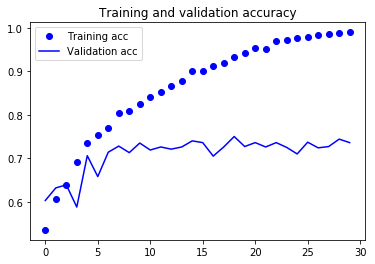

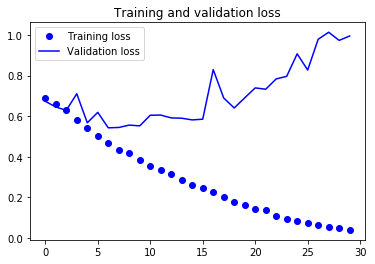

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 그래프는 과대적합의 특성을 보여줍니다. 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달합니다. 반면 검증 정확도는 70-72%에서 멈추었습니다. 검증 손실은 다섯 번의 에포크만에 최솟값에 다다른 이후에 더 이상 진전되지 않았습니다. 반면 훈련 손실은 거의 0에 도달할 때까지 선형적으로 계속 감소합니다.

비교적 훈련 샘플의 수(2,000개)가 적기 때문에 과대적합이 가장 중요한 문제입니다. 드롭아웃이나 가중치 감소(L2 규제)와 같은 과대적합을 감소시킬 수 있는 여러 가지 기법들을 배웠습니다. 여기에서는 컴퓨터 비전에 특화되어 있어서 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인 데이터 증식을 시도해 보겠습니다.

#### **데이터 증식 사용하기**

과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생합니다. 무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것입니다. 데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다. 훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표입니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 `ImageDataGenerator`가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다. 예제를 먼저 만들어 보죠:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

추가적인 매개변수가 몇 개 더 있습니다(케라스 문서를 참고하세요). 이 코드를 간단히 살펴보죠.

* `rotation_range`는 랜덤하게 사진을 회전시킬 각도 범위입니다(0-180 사이).
* `width_shift_range`와 `height_shift_range`는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위입니다(전체 넓이와 높이에 대한 비율).
* `shear_range`는 랜덤하게 전단 변환을 적용할 각도 범위입니다.
* `zoom_range`는 랜덤하게 사진을 확대할 범위입니다.
* `horizontal_flip`은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다(예를 들어, 풍경/인물 사진).
* `fill_mode`는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

증식된 이미지 샘플을 살펴보죠:

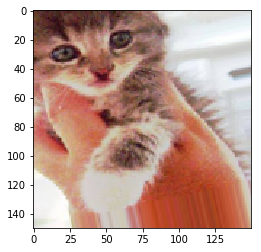

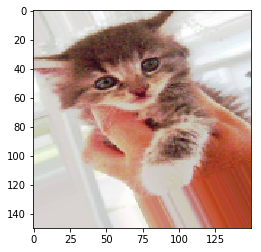

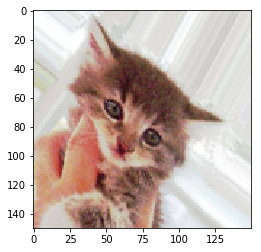

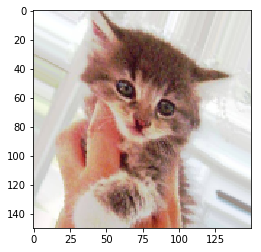

In [ ]:
# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않습니다. 하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큽니다. 즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능합니다. 그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있습니다. 과대적합을 더 억제하기 위해 완전 연결 분류기 직전에 `Dropout` 층을 추가하겠습니다:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

데이터 증식과 드롭아웃을 사용하여 이 네트워크를 훈련시켜 봅시다:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 18s 178ms/step - loss: 0.6883 - acc: 0.5344 - val_loss: 0.6735 - val_acc: 0.5470
Epoch 2/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6705 - acc: 0.5850 - val_loss: 0.6654 - val_acc: 0.5683
Epoch 3/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6566 - acc: 0.6031 - val_loss: 0.6366 - val_acc: 0.6250
Epoch 4/100
100/100 [==============================] - 16s 160ms/step - loss: 0.6311 - acc: 0.6375 - val_loss: 0.6187 - val_acc: 0.6411
Epoch 5/100
100/100 [==============================] - 16s 162ms/step - loss: 0.6194 - acc: 0.6559 - val_loss: 0.5897 - val_acc: 0.6764
Epoch 6/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6006 - acc: 0.6659 - val_loss: 0.5903 - val_acc: 0.6727
Epoch 7/100
100/100 [==============================] - 16s 161ms/step - loss: 0.5963 - acc: 0.6794 -

100/100 [==============================] - 16s 160ms/step - loss: 0.3986 - acc: 0.8169 - val_loss: 0.4489 - val_acc: 0.7938
Epoch 61/100
100/100 [==============================] - 16s 161ms/step - loss: 0.4187 - acc: 0.8034 - val_loss: 0.5667 - val_acc: 0.7513
Epoch 62/100
100/100 [==============================] - 16s 160ms/step - loss: 0.4018 - acc: 0.8172 - val_loss: 0.4424 - val_acc: 0.7951
Epoch 63/100
100/100 [==============================] - 16s 160ms/step - loss: 0.4126 - acc: 0.8156 - val_loss: 0.4498 - val_acc: 0.7990
Epoch 64/100
100/100 [==============================] - 16s 160ms/step - loss: 0.3859 - acc: 0.8369 - val_loss: 0.4335 - val_acc: 0.7938
Epoch 65/100
100/100 [==============================] - 16s 160ms/step - loss: 0.4055 - acc: 0.8125 - val_loss: 0.4269 - val_acc: 0.8135
Epoch 66/100
100/100 [==============================] - 16s 161ms/step - loss: 0.3987 - acc: 0.8153 - val_loss: 0.4446 - val_acc: 0.8054
Epoch 67/100
100/100 [==============================] 

다음 절에서 이 모델을 사용하기 위해 모델을 저장합니다.

In [ ]:
model.save('cats_and_dogs_small_2.h5')

결과 그래프를 다시 그려 보죠:

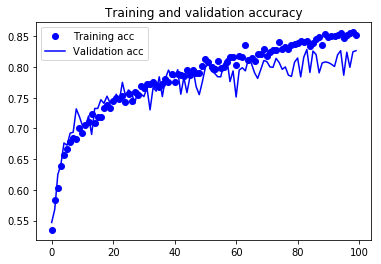

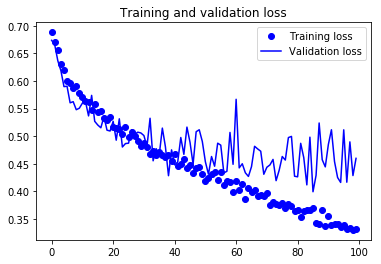

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그림 5-12와 5-13을 참고하세요. 데이터 증식과 드롭아웃 덕택에 더이상 과대적합되지 않습니다. 훈련 곡선이 검증 곡선에 가깝게 따라가고 있습니다. 검증 데이터에서 82% 정확도를 달성하였습니다. 규제하지 않은 모델과 비교했을 때 15% 정도 향상되었습니다.

다른 규제 기법을 더 사용하고 네트워크의 파라미터를 튜닝하면(합성곱 층의 필터 수나 네트워크의 층의 수 등) 86%나 87% 정도까지 더 높은 정확도를 얻을 수도 있습니다. 하지만 데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다. 이런 상황에서 정확도를 높이기 위한 다음 단계는 사전 훈련된 모델을 사용하는 것입니다. 다음 두 절에서 이에 대해 집중적으로 살펴보겠습니다.

### **3. 사전 훈련된 컨브넷 사용하기**

작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 사전 훈련된 네트워크는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다. 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. 예를 들어 (대부분 동물이나 생활 용품으로 이루어진) ImageNet 데이터셋에 네트워크를 훈련합니다. 그다음 이 네트워크를 이미지에서 가구 아이템을 식별하는 것 같은 다른 용도로 사용할 수 있습니다. 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있습니다.

여기에서는 (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있습니다. 그래서 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 것 같습니다.

캐런 시몬연과 앤드류 지서먼이 2014년에 개발한 VGG16 구조를 사용하겠습니다. VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁습니다. 하지만 이 모델의 구조가 이전에 보았던 것과 비슷해서 새로운 개념을 도입하지 않고 이해하기 쉽기 때문에 선택했습니다. 아마 VGG가 처음 보는 모델 애칭일지 모르겠습니다. 이런 이름에는 VGG, ResNet, Inception, Inception-ResNet, Xception 등이 있습니다. 컴퓨터 비전을 위해 딥러닝을 계속 공부하다보면 이런 이름을 자주 만나게 될 것입니다.

사전 훈련된 네트워크를 사용하는 두 가지 방법이 있습니다. 특성 추출과 미세 조정입니다. 이 두 가지를 모두 다루어 보겠습니다. 먼저 특성 추출부터 시작하죠.

#### **특성 추출**

특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

앞서 보았듯이 컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다. 먼저 연속된 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝납니다. 첫 번째 부분을 모델의 합성곱 기반층(convolutional base)이라고 부르겠습니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련합니다.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

왜 합성곱 층만 재사용할까요? 완전 연결 분류기도 재사용할 수 있을까요? 일반적으로 권장하지 않습니다. 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능하기 때문입니다. 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있습니다. 더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않습니다. 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려합니다. 객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없습니다.

특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있습니다. 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출합니다. 반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출합니다. 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다.

ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다. 이런 경우 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 될 것 같습니다. 하지만 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반적인 경우를 다루기 위해서 여기서는 완전 연결 층을 사용하지 않겠습니다.

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련되었습니다):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG16 모델을 만들어 보죠:

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

VGG16 함수에 세 개의 매개변수를 전달합니다:

* `weights`는 모델을 초기화할 가중치 체크포인트를 지정합니다.
* `include_top`은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
* `input_shape`은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

다음은 VGG16 합성곱 기반층의 자세한 구조입니다. 이 구조는 앞에서 보았던 간단한 컨브넷과 비슷합니다.

In [ ]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

최종 특성 맵의 크기는 `(4, 4, 512)`입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다.
이 지점에서 두 가지 방식이 가능합니다.

* 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 이 책의 1부에서 보았던 것과 비슷한 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.
* 준비한 모델(`conv_base`) 위에 `Dense` 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

두 가지 방식을 모두 다루어 보겠습니다. 첫 번째 방식을 구현하는 코드를 살펴봅니다. `conv_base`에 데이터를 주입하고 출력을 기록합니다. 이 출력을 새로운 모델의 입력으로 사용하겠습니다.

먼저 앞서 소개한 `ImageDataGenerator`를 사용해 이미지와 레이블을 넘파이 배열로 추출하겠습니다. `conv_base` 모델의 `predict` 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기는 `(samples, 4, 4, 512)`입니다. 완전 연결 분류기에 주입하기 위해서 먼저 `(samples, 8192)` 크기로 펼칩니다:

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

그러고 나서 완전 연결 분류기를 정의하고(규제를 위해 드롭아웃을 사용합니다) 저장된 데이터와 레이블을 사용해 훈련합니다:

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 349us/step - loss: 0.5855 - acc: 0.6815 - val_loss: 0.4257 - val_acc: 0.8350
Epoch 2/30
2000/2000 [==============================] - 0s 192us/step - loss: 0.4212 - acc: 0.8125 - val_loss: 0.3606 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 0s 191us/step - loss: 0.3555 - acc: 0.8520 - val_loss: 0.3164 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 0s 190us/step - loss: 0.3090 - acc: 0.8720 - val_loss: 0.2925 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 0s 190us/step - loss: 0.2898 - acc: 0.8815 - val_loss: 0.2770 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 0s 190us/step - loss: 0.2631 - acc: 0.8980 - val_loss: 0.2777 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 0s 191us/step - loss: 0.2485 - acc: 0.8990 - val_loss: 0.2631 - val_acc: 0.8980


두 개의 `Dense` 층만 처리하면 되기 때문에 훈련이 매우 빠릅니다. CPU를 사용하더라도 한 에포크에 걸리는 시간이 1초 미만입니다.

훈련 손실과 정확도 곡선을 살펴보죠:

In [ ]:
import matplotlib.pyplot as plt

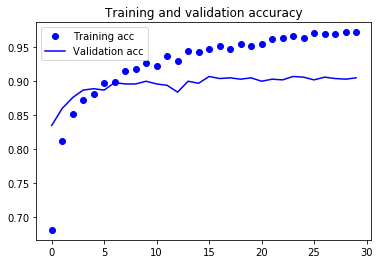

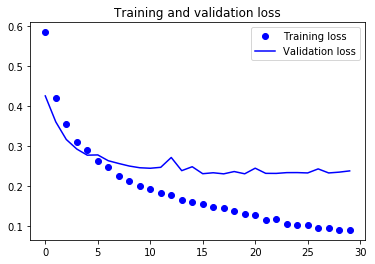

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 이전 절에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

이제 특성 추출을 위해 두 번째로 언급한 방법을 살펴보겠습니다. 이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. `conv_base` 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행합니다.

이 기법은 연산 비용이 크기 때문에 GPU를 사용할 수 있을 때 시도해야 합니다. CPU에서는 적용하기 매우 힘듭니다. GPU를 사용할 수 없다면 첫 번째 방법을 사용하세요.

모델은 층과 동일하게 작동하므로 층을 추가하듯이 `Sequential` 모델에 (`conv_base` 같은) 다른 모델을 추가할 수 있습니다:

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

이 모델의 구조는 다음과 같습니다:

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


여기서 볼 수 있듯이 VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반층 위에 추가한 분류기는 2백만 개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 `Dense` 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 `trainable` 속성을 `False`로 설정하여 네트워크를 동결할 수 있습니다:

In [ ]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [ ]:
conv_base.trainable = False

In [ ]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


이렇게 설정하면 추가한 두 개의 `Dense` 층의 가중치만 훈련될 것입니다. 층마다 두 개씩(가중치 행렬과 편향 벡터) 총 네 개의 텐서가 훈련됩니다. 변경 사항을 적용하려면 먼저 모델을 컴파일해야 합니다. 컴파일 단계 후에 `trainable` 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다. 그렇지 않으면 변경 사항이 적용되지 않습니다.

이제 앞의 예제에서 사용했던 데이터 증식을 사용하여 모델 훈련을 시작할 수 있습니다:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 13s - loss: 0.5570 - acc: 0.7270 - val_loss: 0.4234 - val_acc: 0.8400
Epoch 2/30
 - 12s - loss: 0.4198 - acc: 0.8200 - val_loss: 0.3483 - val_acc: 0.8640
Epoch 3/30
 - 12s - loss: 0.3629 - acc: 0.8465 - val_loss: 0.3108 - val_acc: 0.8840
Epoch 4/30
 - 12s - loss: 0.3393 - acc: 0.8495 - val_loss: 0.2935 - val_acc: 0.8870
Epoch 5/30
 - 12s - loss: 0.3065 - acc: 0.8725 - val_loss: 0.2746 - val_acc: 0.8930
Epoch 6/30
 - 12s - loss: 0.2984 - acc: 0.8760 - val_loss: 0.2674 - val_acc: 0.8980
Epoch 7/30
 - 12s - loss: 0.2842 - acc: 0.8890 - val_loss: 0.2665 - val_acc: 0.9040
Epoch 8/30
 - 12s - loss: 0.2699 - acc: 0.8840 - val_loss: 0.2505 - val_acc: 0.9010
Epoch 9/30
 - 12s - loss: 0.2674 - acc: 0.8920 - val_loss: 0.2468 - val_acc: 0.8960
Epoch 10/30
 - 12s - loss: 0.2533 - acc: 0.8940 - val_loss: 0.2481 - val_acc: 0.9020
Epoch 11/30
 - 12s - loss: 0.2524 - acc: 0.8940 - val_loss: 0.2436 - val_ac

In [ ]:
model.save('cats_and_dogs_small_3.h5')

결과 그래프를 다시 그려 봅시다:

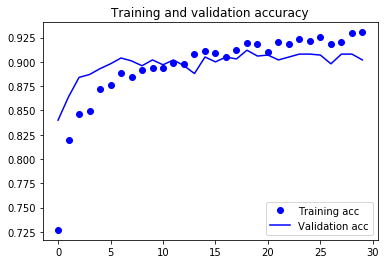

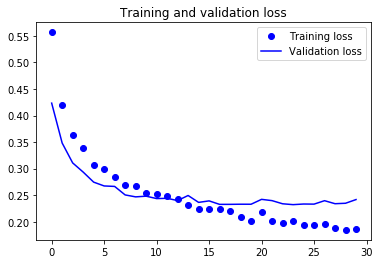

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

여기서 볼 수 있듯이 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.

#### **미세 조정**

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

앞서 랜덤하게 초기화된 상단 분류기를 훈련하기 위해 VGG16의 합성곱 기반층을 동결해야 한다고 말했습니다. 같은 이유로 맨 위에 있는 분류기가 훈련된 후에 합성곱 기반의 상위 층을 미세 조정할 수 있습니다. 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됩니다. 이는 미세 조정될 층들이 사전에 학습한 표현들을 망가뜨리게 될 것입니다. 네트워크를 미세 조정하는 단계는 다음과 같습니다:

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

처음 세 단계는 특성 추출을 할 때 이미 완료했습니다. 네 번째 단계를 진행해 보죠. `conv_base`의 동결을 해제하고 개별 층을 동결하겠습니다.

기억을 되살리기 위해 합성곱 기반층의 구조를 다시 확인해 보겠습니다:

In [ ]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

마지막 세 개의 합성곱 층을 미세 조정하겠습니다. 즉, `block4_pool`까지 모든 층은 동결되고 `block5_conv1`, `block5_conv2`, `block5_conv3` 층은 학습 대상이 됩니다.

왜 더 많은 층을 미세 조정하지 않을까요? 왜 전체 합성곱 기반층을 미세 조정하지 않을까요? 그렇게 할 수도 있지만 다음 사항을 고려해야 합니다:

* 합성곱 기반층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면 상위 층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다. 하위 층으로 갈수록 미세 조정에 대한 효과가 감소합니다.
* 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반층은 1천 5백만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

그러므로 이런 상황에서는 합성곱 기반층에서 최상위 두 세개의 층만 미세 조정하는 것이 좋습니다.

앞선 예제 코드에 이어서 미세 조정을 설정해보죠:

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

이제 네트워크의 미세 조정을 시작하겠습니다. 학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. 학습률을 낮추는 이유는 미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.

미세 조정을 진행해 보죠:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 14s 139ms/step - loss: 0.1986 - acc: 0.9230 - val_loss: 0.2034 - val_acc: 0.9150
Epoch 2/100
100/100 [==============================] - 13s 133ms/step - loss: 0.1617 - acc: 0.9290 - val_loss: 0.2445 - val_acc: 0.9060
Epoch 3/100
100/100 [==============================] - 13s 133ms/step - loss: 0.1348 - acc: 0.9485 - val_loss: 0.2170 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 13s 133ms/step - loss: 0.1268 - acc: 0.9520 - val_loss: 0.2563 - val_acc: 0.9030
Epoch 5/100
100/100 [==============================] - 13s 133ms/step - loss: 0.1075 - acc: 0.9585 - val_loss: 0.2591 - val_acc: 0.9030
Epoch 6/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0964 - acc: 0.9680 - val_loss: 0.1927 - val_acc: 0.9290
Epoch 7/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0753 - acc: 0.9720 - val_loss: 0.2350 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0023 - acc: 0.9990 - val_loss: 0.3891 - val_acc: 0.9220
Epoch 62/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0080 - acc: 0.9985 - val_loss: 0.2921 - val_acc: 0.9430
Epoch 63/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0048 - acc: 0.9990 - val_loss: 0.4222 - val_acc: 0.9270
Epoch 64/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0091 - acc: 0.9980 - val_loss: 0.3626 - val_acc: 0.9340
Epoch 65/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.3837 - val_acc: 0.9340
Epoch 66/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0039 - acc: 0.9985 - val_loss: 0.3066 - val_acc: 0.9390
Epoch 67/100
100/100 [==============================] - 13s 133ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.3340 - val_acc: 0.9380
Epoch 68/100
100/100 [===================

In [ ]:
model.save('cats_and_dogs_small_4.h5')

이전과 동일한 코드로 결과 그래프를 그려 보겠습니다:

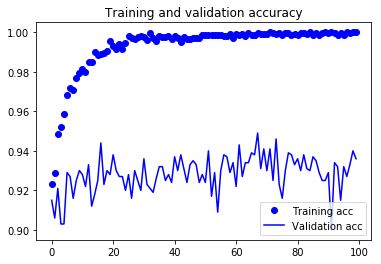

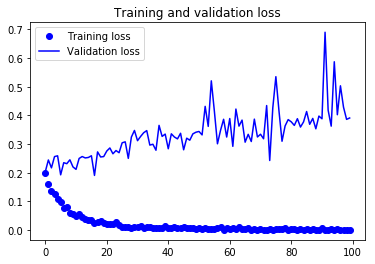

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프가 불규칙하게 보입니다. 그래프를 보기 쉽게하기 위해 지수 이동 평균으로 정확도와 손실 값을 부드럽게 표현할 수 있습니다. 다음은 지수 이동 평균을 구하기 위한 간단한 함수입니다:

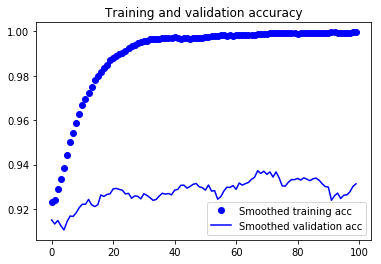

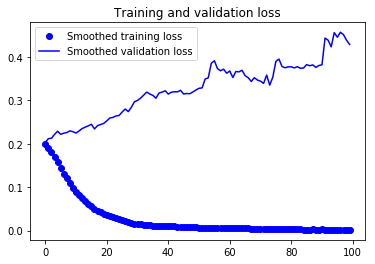

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도 곡선이 훨씬 깨끗하게 보입니다. 정확도가 확실히 1% 이상 향상되었습니다.

손실 곡선은 실제 어떤 향상을 얻지 못했습니다(사실 악화되었습니다). 손실히 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요? 답은 간단합니다. 그래프는 개별적인 손실 값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아닙니다. 정확도는 모델이 예측한 클래스 확률이 어떤 임계값을 넘었는지에 대한 결과이기 때문입니다. 모델이 더 향상더라도 평균 손실에 반영되지 않을 수 있습니다.

이제 마지막으로 테스트 데이터에서 이 모델을 평가하겠습니다:

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9409999907016754


92%의 테스트 정확도를 얻을 것입니다. 이 데이터셋을 사용한 원래 캐글 경연 대회에서 꽤 높은 순위입니다. 하지만 최신 딥러닝 기법으로 훈련 데이터의 일부분(약 10%)만을 사용해서 이런 결과를 달성했습니다. 20,000개의 샘플에서 훈련하는 것과 2,000개의 샘플에서 훈련하는 것 사이에는 아주 큰 차이점이 있습니다!

### 정리

다음은 앞의 두 절에 있는 예제로부터 배운 것들입니다.

* 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.
* 작은 데이터셋에서는 과대적합이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법입니다.
* 특성 추출 방식으로 새로운 데이터셋에 기존의 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.
* 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.

지금까지 이미지 분류 문제에서 특히 작은 데이터셋을 다루기 위한 좋은 도구들을 배웠습니다.